## Paquid Data Test

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
from lifelines import ExponentialFitter
from sklearn.neighbors import KernelDensity

import jmstate
from jmstate import MultiStateJointModel
from jmstate.typedefs import *
from jmstate.utils import *

In [2]:
paquid = pd.read_csv("data/paquid.csv")

   ID  MMSE  BVRT   IST  HIER  CESD        age     agedem  dem  age_init  CEP  \
0   1  26.0  10.0  37.0   2.0  11.0  68.506300  68.506300    0   67.4167    1   
1   2  26.0  13.0  25.0   1.0  10.0  66.995400  85.616701    1   65.9167    1   
2   2  28.0  13.0  28.0   1.0  15.0  69.095300  85.616701    1   65.9167    1   
3   2  25.0  12.0  23.0   1.0  18.0  73.807200  85.616701    1   65.9167    1   
4   2  24.0  13.0  16.0   3.0  22.0  84.142368  85.616701    1   65.9167    1   

   male  
0     1  
1     0  
2     0  
3     0  
4     0  


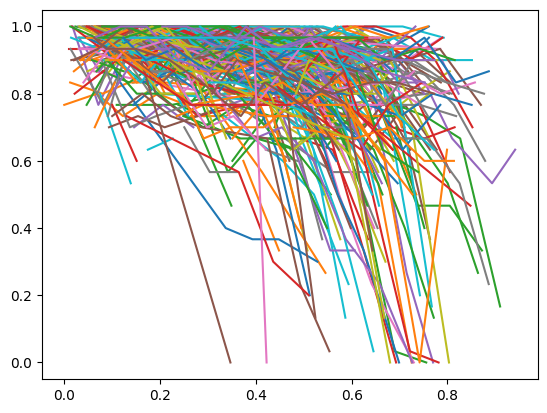

In [3]:
def get_ages(id):
    T = []
    for k in range(4):
        mask = (paquid["ID"].values == id) & (paquid["HIER"].values == k)
        if sum(mask) > 0:
            T.append((min(paquid["age"][mask]), k))

    if len(T) <= 1:
        return T

    result = [T[0]]

    for i in range(1, len(T)):
        if T[i][0] >= result[-1][0]:
            result.append(T[i])

    return result


def last_non_nan(y: torch.Tensor) -> torch.Tensor:
    mask = ~torch.isnan(y).any(dim=2)  # shape (n_samples, n_timepoints)
    reversed_mask = mask.flip(dims=[1])
    last_idx_from_end = reversed_mask.double().cumsum(dim=1).argmax(dim=1)
    last_idx = y.shape[1] - 1 - last_idx_from_end
    # Gather the last valid values using advanced indexing
    return y[torch.arange(y.shape[0]), last_idx]


def get_last_visit_age(id):
    return paquid[paquid["ID"] == id]["age"].max()
def get_t(id):
    return torch.tensor(paquid[paquid["ID"] == id]["age"].values)
def get_X(id):
    return torch.tensor(paquid[paquid["ID"] == id]["CEP"].min())
def get_Y(id):
    return torch.tensor(paquid[paquid["ID"] == id]["MMSE"].values)

ids = range(1, 501)
trajectories = [get_ages(id) for id in ids]
c = torch.tensor([get_last_visit_age(id) for id in ids]).view(-1, 1)
t = torch.nn.utils.rnn.pad_sequence(
    [get_t(id) for id in ids], batch_first=True, padding_value=torch.nan
)
x = torch.tensor([[get_X(id)] for id in ids])
y = torch.nn.utils.rnn.pad_sequence(
    [get_Y(id) for id in ids], batch_first=True, padding_value=torch.nan
)[..., None]

y = (y - torch.nanquantile(y, 0)) / (torch.nanquantile(y, 1) - torch.nanquantile(y, 0))
trajectories = [
    [
        (
            (
                (m - torch.nanquantile(t, 0).item())
                / (torch.nanquantile(t, 1) - torch.nanquantile(t, 0)).item()
            ),
            s,
        )
        for (m, s) in trajectory
    ]
    for trajectory in trajectories
]
t = (t - torch.nanquantile(t, 0)) / (torch.nanquantile(t, 1) - torch.nanquantile(t, 0))


plt.plot(t.T, y[:, :, 0].T)
plt.show()

In [4]:
buckets = build_buckets(trajectories)

dict_keys([(1, 3), (0, 1), (1, 2), (0, 2), (2, 3), (0, 3)])


In [5]:
surv_params = {}
for key, value in buckets.items():
    t0, t1 = value.t0, value.t1
    exp_fit = ExponentialFitter().fit(t1 - t0)
    surv_params[key] = exp_fit.lambda_

In [6]:
def f(gamma, x, b):
    return b


from torch import nn

net = nn.Sequential(
    nn.Linear(5, 3),
    nn.Tanh(),
    nn.Linear(3, 3),
    nn.Tanh(),
    nn.Linear(3, 1),
    nn.Sigmoid()
)

reg = jmstate.functions.Net(net)

surv = {
    key: (jmstate.functions.exponential(surv_params[key]), reg)
    for key in buckets
}

init_alphas = {key: torch.zeros(1) for key in buckets}
init_betas = None

init_params = ModelParams(
    None,
    repr_from_cov(torch.eye(4), method="diag"),
    repr_from_cov(torch.eye(1), method="ball"),
    init_alphas,
    init_betas,
    extra=list(reg.parameters())
)

model_design = ModelDesign(
    f,
    reg,
    surv,
)

In [7]:
data = ModelData(None, t, y, trajectories, c)

Running joint model: 100%|██████████| 2500/2500 [00:46<00:00, 53.78it/s]


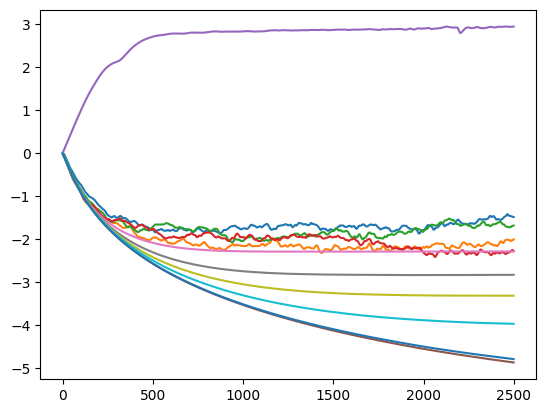

In [8]:
def pen(params: ModelParams):
    return 0.1 * sum(p.pow(2).sum() for p in params.extra)

model = MultiStateJointModel(model_design, init_params)
metrics = model.do(
    data,
    jobs=[
        jmstate.jobs.RandomFit(lr=1e-2),
        jmstate.jobs.LogParamsHistory(),
    ],
    max_iterations=2500,
    n_chains=1,
    n_steps=2
)

plt.plot(torch.cat([p.as_flat_tensor[None] for p in metrics], dim=0))
plt.show()

Parameter containing:
tensor([1.3714])
Parameter containing:
tensor([1.3714])
ModelParams(gamma=None, Q_repr=MatRepr(flat=tensor([-1.4884, -2.0055, -1.6848, -2.2781]), dim=4, method='diag'), R_repr=MatRepr(flat=tensor([2.9467]), dim=1, method='ball'), alphas={(1, 3): tensor([-4.8732]), (0, 1): tensor([-2.2874]), (1, 2): tensor([-2.8321]), (0, 2): tensor([-3.3182]), (2, 3): tensor([-3.9724]), (0, 3): tensor([-4.7942])}, betas=None)


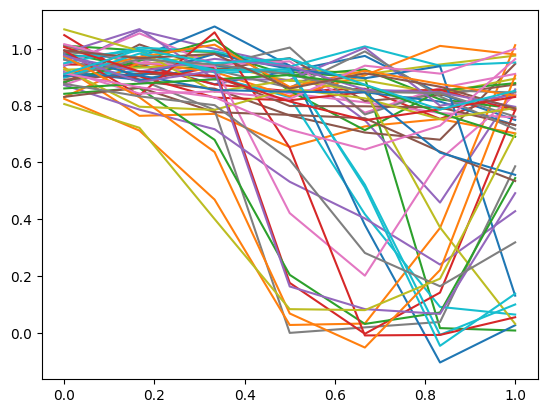

In [13]:
n_test = 50
t_test = torch.linspace(0, 1, 7)

Q_dist = torch.distributions.MultivariateNormal(
    torch.zeros(4), model.params_.get_cov("Q")
)
R_dist = torch.distributions.MultivariateNormal(
    torch.zeros(1), model.params_.get_cov("R")
)

x_test = KernelDensity().fit(x).sample(n_test)
b_test = Q_dist.sample((n_test,))
psi_test = f(model.params_.gamma, None, b_test)
trajectories_init_test = [[(0.0, 0)] for _ in range(n_test)]
y_test = model_design.regression_fn(t_test, psi_test).squeeze(0)
y_test += R_dist.sample(y_test.shape[:-1])
plt.plot(t_test.T, y_test[:, :, 0].T)
plt.show()